In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import cross_validation
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('apgar.csv')
df.dropna(inplace = True)

In [3]:
df['norm_birth'] = preprocessing.scale(df['bthwght']) # Normalizing birthweight. 
df = df.assign(apg8 = np.where(df['apgar5'] <= 8, 1,0)) # Dummy variable for children: 1[Apgar <= 8]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [4]:
X = pd.DataFrame() # Exogenous Variables...
X['1-degree'] = df['norm_birth']
X['2-degree'] = X['1-degree']**2
X['3-degree'] = X['1-degree']**3
X['4-degree'] = X['1-degree']**4
X['5-degree'] = X['1-degree']**5
X['6-degree'] = X['1-degree']**6
X = X.assign(low = np.where(X['1-degree'] < -2, 1,0)) 
X = X.assign(high = np.where(X['1-degree'] > 2, 1,0))
X = sm.add_constant(X)
Y = df['apg8']
X['height'] = df['height']

In [5]:
model1 = sm.OLS(Y, X.iloc[:,0:2]).fit()
model2 = sm.OLS(Y, X.iloc[:,0:3]).fit()
model3 = sm.OLS(Y, X.iloc[:,0:4]).fit()
model4 = sm.OLS(Y, X.iloc[:,0:5]).fit()
model5 = sm.OLS(Y, X.iloc[:,0:6]).fit()
model6 = sm.OLS(Y, X.iloc[:,0:7]).fit()
model7 = sm.OLS(Y, X[['1-degree','2-degree','3-degree',\
                             '4-degree', '1-degree',\
                      'high','low','const']]).fit()
model8 = sm.OLS(Y, X[['const','1-degree','2-degree','3-degree',\
                     '4-degree','height']]).fit()


In [6]:
# Calculates the RMSE for upcoming model evaluation.
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [7]:
models = [model1,model2,model3,model4,\
          model5,model6,model7, model8]
model_name =['model1','model2','model3',\
             'model4','model5','model6','model7','model8']

# Appends the RMSE score for each model to a list. 
model_rmse = []
for i, j in zip(models,model_name):
    model_rmse.append(rmse(i.predict(),Y))

    
    

In [8]:
model_rmse = list(zip(model_name, model_rmse)) #List of tuples: (modelname, rmse)

In [9]:
rmses = pd.DataFrame(model_rmse, columns = {'rmse','model'})
rmses = rmses.set_index('model')




In [10]:
print(rmses.sort_values(by = 'rmse', ascending = True))

            rmse
model           
model8  0.252436
model6  0.252445
model5  0.252445
model7  0.252445
model4  0.252447
model3  0.252464
model2  0.252490
model1  0.252585


On the table above, it is clear that if we are determining our model through the RMSE criterion, model8 has the best within sample fit:

$1[Apgar <= 8] = \beta_0x + \beta_1x^2 + \beta_3x^3 + \beta_4x^4 +\beta_5Apgar  $ 

Part B. 
We will now compare the models using an out-of-sample comparison based on 5-fold cross-validation. 

In [11]:
model = linear_model.LinearRegression()


# Generate cross-validated estimates for each input data point.
predicted1 = cross_val_predict(model,X.iloc[:,0:2], Y, cv = 5)
predicted2 = cross_val_predict(model,X.iloc[:,0:3], Y, cv = 5)
predicted3 = cross_val_predict(model,X.iloc[:,0:4], Y, cv = 5)
predicted4 = cross_val_predict(model,X.iloc[:,0:5], Y, cv = 5)
predicted5 = cross_val_predict(model,X.iloc[:,0:6], Y, cv = 5)
predicted6 = cross_val_predict(model,X.iloc[:,0:7], Y, cv = 5)
predicted7 = cross_val_predict(model,X[['1-degree',\
                                        '2-degree','3-degree',\
                                        '4-degree', '1-degree',\
                                        'high','low','const']], Y, cv = 5)
predicted8 = cross_val_predict(model,X[['const','1-degree',\
                                        '2-degree','3-degree',\
                                        '4-degree','height']], Y, cv = 5)




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [12]:
model_predict = [predicted1,predicted2,predicted3,predicted4,predicted5,predicted6,predicted7, predicted8, ]
model_name =['predicted1','predicted2','predicted3','predicted4','predicted5',\
             'predicted6','predicted7','predicted8']

model_rmse = []
for i, j in zip(model_predict,model_name):
    model_rmse.append(rmse(i,Y))
    
model_rmse = list(zip(model_name, model_rmse))
rmses = pd.DataFrame(model_rmse, columns = {'rmse','model'})
rmses = rmses.set_index('model')
print(rmses.sort_values(by = 'rmse', ascending = True))



                rmse
model               
predicted8  0.252494
predicted4  0.252495
predicted5  0.252501
predicted3  0.252502
predicted7  0.252502
predicted6  0.252505
predicted2  0.252524
predicted1  0.252595


As in part A, the RMSE criterion for the out of sample fit denotes model8 as the best model.

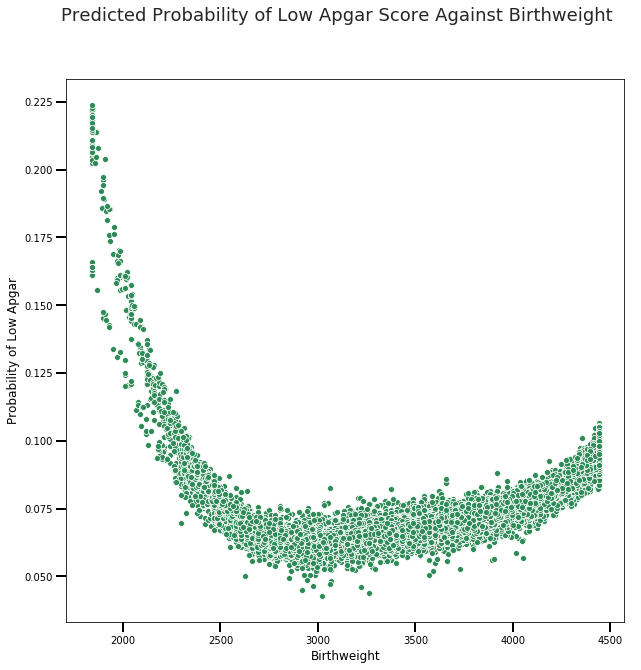

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.set()
ax = sns.scatterplot(df['bthwght'],predicted8, color = '#2E8B57')
fig.suptitle('Predicted Probability of Low Apgar Score Against Birthweight', fontsize=18)
ax.set_xlabel("Birthweight",fontsize=12)
ax.set_ylabel("Probability of Low Apgar",fontsize=12)
ax.tick_params(direction='out', length=10, width=2, grid_alpha=0.5,labelsize = 10)